# Libraries import

In [1]:
import numpy as np
import scipy.io
from matplotlib import pyplot as plt
from brian2 import *
import pandas as pd
from scipy import signal
from brian2hears import *
from sklearn.metrics import precision_score,recall_score,f1_score
import time 

# Normal data loading and plots

In [5]:
ibf_normal_exp1=scipy.io.loadmat('baseline_1.mat')
ibf_normal_exp2=scipy.io.loadmat('baseline_2.mat')
ibf_normal_exp3=scipy.io.loadmat('baseline_3.mat')

ibf_normal_exp1 = ibf_normal_exp1["bearing"][0][0][1]
ibf_normal_exp2 = ibf_normal_exp2["bearing"][0][0][1]
ibf_normal_exp3 = ibf_normal_exp3["bearing"][0][0][1]

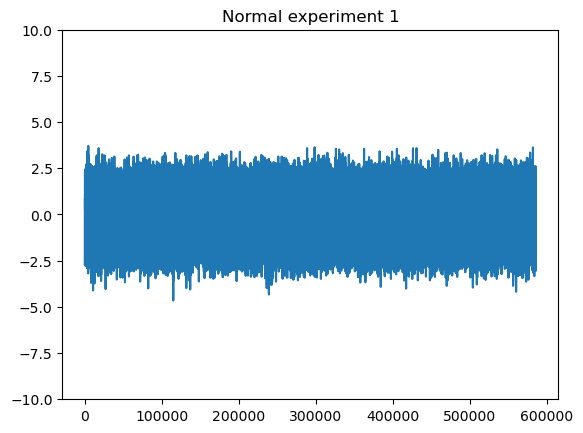

In [7]:
plt.plot(ibf_normal_exp1)
plt.title("Normal experiment 1")
plt.ylim(-10,10)
plt.show()

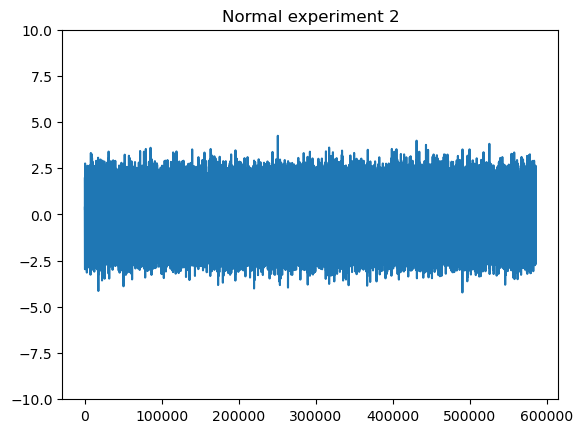

In [8]:
plt.plot(ibf_normal_exp2)
plt.title("Normal experiment 2")
plt.ylim(-10,10)
plt.show()

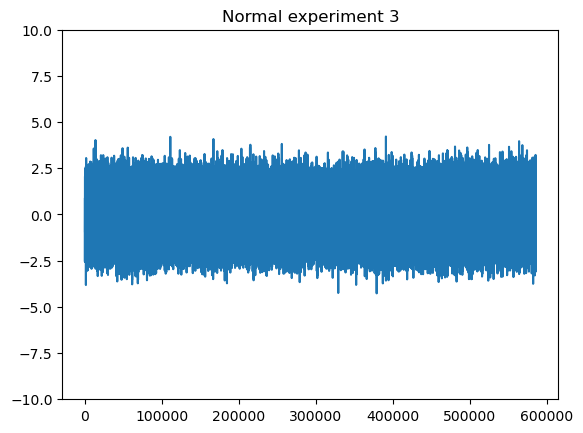

In [9]:
plt.plot(ibf_normal_exp3)
plt.title("Normal experiment 3")
plt.ylim(-10,10)
plt.show()

# Anomaly data loading and plots

In [16]:
ibf_anomaly_exp4 = scipy.io.loadmat('OuterRaceFault_1.mat')
ibf_anomaly_exp5 = scipy.io.loadmat('OuterRaceFault_2.mat')
ibf_anomaly_exp6 = scipy.io.loadmat('OuterRaceFault_3.mat')

ibf_anomaly_exp4 = ibf_anomaly_exp4["bearing"][0][0][2]
ibf_anomaly_exp5 = ibf_anomaly_exp5["bearing"][0][0][2]
ibf_anomaly_exp6 = ibf_anomaly_exp6["bearing"][0][0][2]

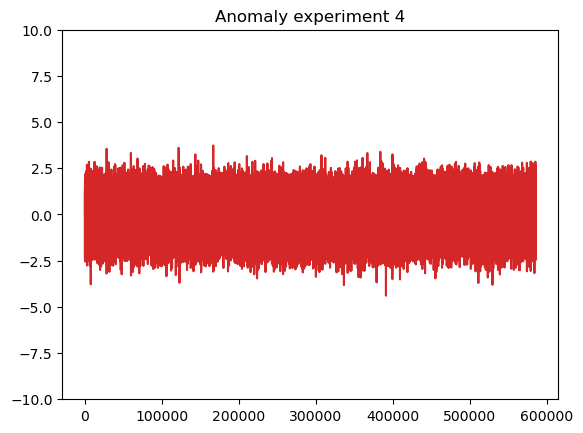

In [17]:
plt.plot(ibf_anomaly_exp4,color="tab:red")
plt.title("Anomaly experiment 4")
plt.ylim(-10,10)
plt.show()

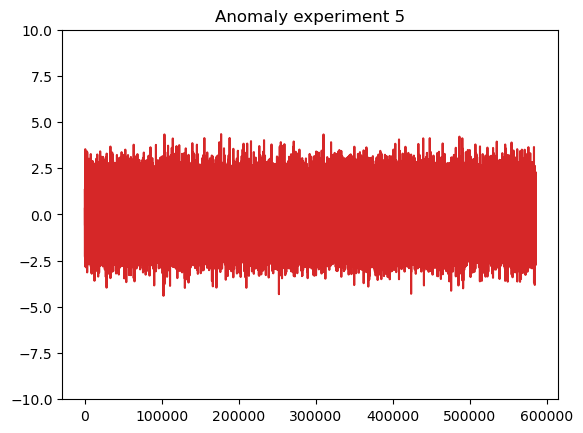

In [18]:
plt.plot(ibf_anomaly_exp5,color="tab:red")
plt.title("Anomaly experiment 5")
plt.ylim(-10,10)
plt.show()

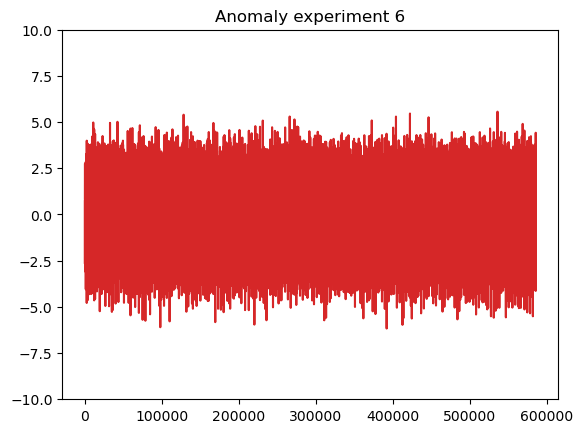

In [19]:
plt.plot(ibf_anomaly_exp6,color="tab:red")
plt.title("Anomaly experiment 6")
plt.ylim(-10,10)
plt.show()

# Gammatone filter processing

In [20]:
SAMPLE_RATE = 97656
N_OF_CHANNELS = 16

In [21]:
center_freqs = np.logspace(np.log10(40),np.log10(48828),N_OF_CHANNELS)
center_frequencies = Quantity(center_freqs*Hz)

In [22]:
center_freqs

array([4.00000000e+01, 6.42441993e+01, 1.03182929e+02, 1.65722616e+02,
       2.66167919e+02, 4.27493622e+02, 6.86599636e+02, 1.10275110e+03,
       1.77113403e+03, 2.84462720e+03, 4.56876992e+03, 7.33792413e+03,
       1.17854765e+04, 1.89287126e+04, 3.04014996e+04, 4.88280000e+04])

In [23]:
signal_normal_exp1 = Sound(ibf_normal_exp1,samplerate=SAMPLE_RATE*Hz)
signal_normal_exp2 = Sound(ibf_normal_exp2,samplerate=SAMPLE_RATE*Hz)
signal_normal_exp3 = Sound(ibf_normal_exp3,samplerate=SAMPLE_RATE*Hz)

signal_anomaly_exp4 = Sound(ibf_anomaly_exp4,samplerate=SAMPLE_RATE*Hz)
signal_anomaly_exp5 = Sound(ibf_anomaly_exp5,samplerate=SAMPLE_RATE*Hz)
signal_anomaly_exp6 = Sound(ibf_anomaly_exp6,samplerate=SAMPLE_RATE*Hz)

In [24]:
gammatone1 = Gammatone(signal_normal_exp1, center_frequencies)
gammatone_normal_exp1 = gammatone1.process()

gammatone2 = Gammatone(signal_normal_exp2, center_frequencies)
gammatone_normal_exp2 = gammatone2.process()

gammatone3 = Gammatone(signal_normal_exp3, center_frequencies)
gammatone_normal_exp3 = gammatone3.process()

gammatone4 = Gammatone(signal_anomaly_exp4, center_frequencies)
gammatone_anomaly_exp4 = gammatone4.process()

gammatone5 = Gammatone(signal_anomaly_exp5, center_frequencies)
gammatone_anomaly_exp5 = gammatone5.process()

gammatone6 = Gammatone(signal_anomaly_exp6, center_frequencies)
gammatone_anomaly_exp6 = gammatone6.process()

WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]


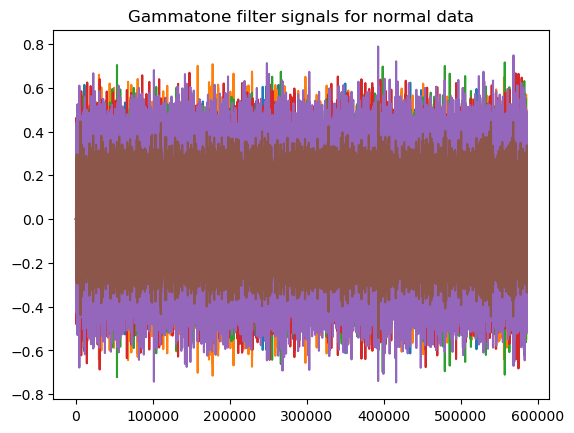

In [25]:
for i in range(gammatone_normal_exp1.shape[1]):
    plt.plot(gammatone_normal_exp1[:,i])
plt.title("Gammatone filter signals for normal data")
plt.show()

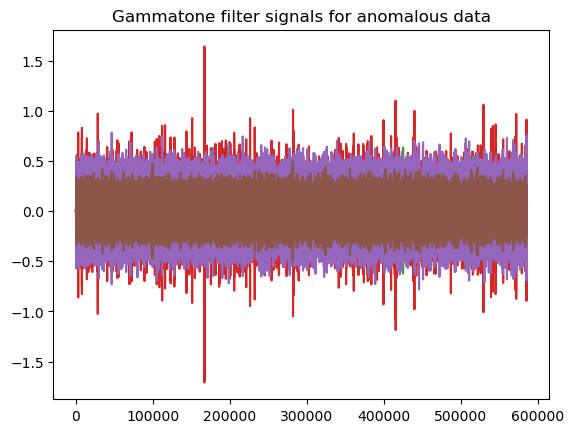

In [26]:
for i in range(gammatone_anomaly_exp4.shape[1]):
    plt.plot(gammatone_anomaly_exp4[:,i])
plt.title("Gammatone filter signals for anomalous data")
plt.show()

# Adaptive Delta Modulation and Spike trains generation

In [27]:
def generate_spikes(V_in, V_up, V_dn, f_s, t_r, debug=True):
    dt = 1/f_s
    T = len(V_in)*dt
    times = np.linspace(0,T,num=len(V_in), endpoint=False)
    V_dc = V_in[0]
    freeze = 0
    spike_times_up = []
    spike_times_dn = []
    recon_signal = []
    for t in range(len(times)):
        if freeze >= 0:
            freeze -= dt
        else:
            if (V_dc + V_up) < V_in[t]:
                spike_times_up.append(times[t])
                V_dc = V_in[t]
                freeze = t_r
            if (V_dc - V_dn) > V_in[t]:
                spike_times_dn.append(times[t])
                V_dc = V_in[t]
                freeze = t_r
        recon_signal.append(V_dc)
    if debug:
        print("Spikes ratio: ", len(spike_times_up)/len(times))
        print("Spikes: ", len(spike_times_up))
    return spike_times_up, spike_times_dn,recon_signal

In [29]:
REFRACTORY_TIME = 0.0003
PLOT = False

spike_train_normal_exp1 = []
spike_train_normal_exp2 = []
spike_train_normal_exp3 = []

spike_train_anomaly_exp4 = []
spike_train_anomaly_exp5 = []
spike_train_anomaly_exp6 = []

# We use the first 3 seconds to compute the variance
END = 3000000

# Variance multiplicative factors
values = np.arange(10,18,0.5)

for i in range(N_OF_CHANNELS):
    print(f"Channel-{i}")
    
    thr1 = np.var(gammatone_normal_exp1[:,i][0:END])*values[i]
    thr2 = np.var(gammatone_normal_exp2[:,i][0:END])*values[i]
    thr3 = np.var(gammatone_normal_exp3[:,i][0:END])*values[i]

    thr4 = np.var(gammatone_anomaly_exp4[:,i][0:END])*values[i]
    thr5 = np.var(gammatone_anomaly_exp5[:,i][0:END])*values[i]
    thr6 = np.var(gammatone_anomaly_exp6[:,i][0:END])*values[i]
    
    spk_exp1,_,_ = generate_spikes(gammatone_normal_exp1[:,i],thr1,thr1,f_s=SAMPLE_RATE,t_r=REFRACTORY_TIME)
    spk_exp2,_,_ = generate_spikes(gammatone_normal_exp2[:,i],thr2,thr2,f_s=SAMPLE_RATE,t_r=REFRACTORY_TIME)
    spk_exp3,_,_ = generate_spikes(gammatone_normal_exp3[:,i],thr3,thr3,f_s=SAMPLE_RATE,t_r=REFRACTORY_TIME)
    
    spk_exp4,_,_ = generate_spikes(gammatone_anomaly_exp4[:,i],thr4,thr4,f_s=SAMPLE_RATE,t_r=REFRACTORY_TIME)
    spk_exp5,_,_ = generate_spikes(gammatone_anomaly_exp5[:,i],thr5,thr5,f_s=SAMPLE_RATE,t_r=REFRACTORY_TIME)
    spk_exp6,_,_ = generate_spikes(gammatone_anomaly_exp6[:,i],thr6,thr6,f_s=SAMPLE_RATE,t_r=REFRACTORY_TIME)
    
    print("==========================")
    
    spike_train_normal_exp1.append(spk_exp1)
    spike_train_normal_exp2.append(spk_exp2)
    spike_train_normal_exp3.append(spk_exp3)
    
    spike_train_anomaly_exp4.append(spk_exp4)
    spike_train_anomaly_exp5.append(spk_exp5)
    spike_train_anomaly_exp6.append(spk_exp6)

Channel-0
Spikes ratio:  0.00517121323830589
Spikes:  3030
Spikes ratio:  0.0051473198438054665
Spikes:  3016
Spikes ratio:  0.0047684388738701835
Spikes:  2794
Spikes ratio:  0.004696758690368914
Spikes:  2752
Spikes ratio:  0.005432333906774801
Spikes:  3183
Spikes ratio:  0.004712118729690615
Spikes:  2761
Channel-1
Spikes ratio:  0.00683692416919254
Spikes:  4006
Spikes ratio:  0.0068300974850495615
Spikes:  4002
Spikes ratio:  0.006263482701182382
Spikes:  3670
Spikes ratio:  0.006335162884683651
Spikes:  3712
Spikes ratio:  0.007333565440594194
Spikes:  4297
Spikes ratio:  0.006045028808607083
Spikes:  3542
Channel-2
Spikes ratio:  0.008843969307228094
Spikes:  5182
Spikes ratio:  0.008866156030692771
Spikes:  5195
Spikes ratio:  0.009072663226017859
Spikes:  5316
Spikes ratio:  0.008980502990087654
Spikes:  5262
Spikes ratio:  0.008765462439583845
Spikes:  5136
Spikes ratio:  0.008879809398978727
Spikes:  5203
Channel-3
Spikes ratio:  0.008091327380464761
Spikes:  4741
Spikes ra

# Data organization

In [39]:
indices_train = []
times_train = []

indices_test = []
times_test = []

# Train data
for ch in range(len(spike_train_normal_exp1)):
    indices_train.extend([ch]*len(spike_train_normal_exp1[ch]))
    times_train.extend(spike_train_normal_exp1[ch])
for ch in range(len(spike_train_normal_exp1)):
    indices_train.extend([ch]*len(spike_train_normal_exp1[ch]))
    shift_train = np.array(spike_train_normal_exp1[ch])+6.0
    shift_train = shift_train.tolist()
    times_train.extend(shift_train)
times_train *= second
    
for ch in range(len(spike_train_normal_exp2)):
    indices_test.extend([ch]*len(spike_train_normal_exp2[ch]))
    times_test.extend(spike_train_normal_exp2[ch])
for ch in range(len(spike_train_anomaly_exp4)):
    indices_test.extend([ch]*len(spike_train_anomaly_exp4[ch]))
    shift_test = np.array(spike_train_anomaly_exp4[ch])+6.0
    shift_test = shift_test.tolist()
    times_test.extend(shift_test)
times_test *= second


# Test signal

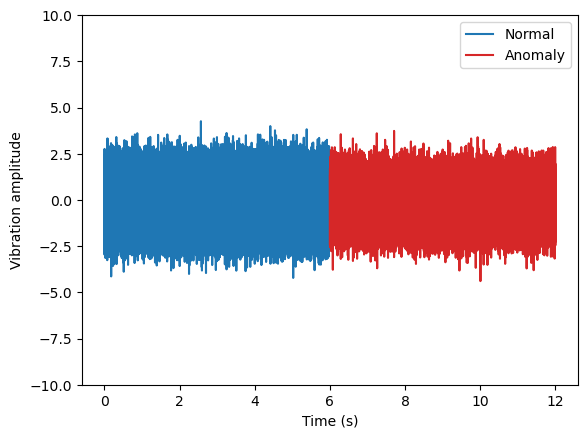

In [44]:
test_signal = np.concatenate((np.zeros((len(ibf_normal_exp2),1))*np.nan,ibf_anomaly_exp4),axis=0)
plt.plot(np.arange(len(ibf_normal_exp2))*(1/SAMPLE_RATE),ibf_normal_exp2,color="tab:blue",label="Normal")
plt.plot(np.arange(len(test_signal))*(1/SAMPLE_RATE),test_signal,color="tab:red",label="Anomaly")
plt.ylim(-10,10)
plt.ylabel("Vibration amplitude")
plt.xlabel("Time (s)")
plt.legend(loc="best")
plt.show()

# BSNN definition and training

In [40]:
w_exc_stored = None
w_inh_stored = None

In [41]:
start_scope()
RELOAD = True
SPIKE_TOLERANCE = 30
COUNTER = 0

N = 16 # Number of input and hidden neurons
tau = 140*ms    # Membrane decay constant
E_l =-70.6*mV   # Rest potantial
V_th= -40.4*mV  # Neuron threshold voltage
V_r= -70.6*mV   # Reset voltage
E = 1 * mV 
dt = 10*usecond
taupre = taupost = 20*ms # 20 * ms
gmax = 3 # Maximum weight
DURATION = 12000000*usecond 

# LIF model
eqs = '''
    dvm/dt= (E_l - vm)/ tau: volt
'''


while True:

    print("Training...")
    
    dApre_inh = (gmax/(N-1))/10 # / 10
    dApre_exc = (gmax/(N-1))/100 # /100

    dApost_inh = dApre_inh
    dApost_exc = dApre_exc
    
    G_input = SpikeGeneratorGroup(N, indices_train, times_train,dt=dt)
    G_hidden = NeuronGroup(N, eqs, threshold='vm>V_th', reset='vm = V_r', method='euler',dt=dt)
    G_output = NeuronGroup(1, eqs, threshold='vm>V_th', reset='vm = V_r', method='euler',dt=dt)

    # Excitatory synapses
    S_exc = Synapses(G_input, G_hidden,
             '''
                w : 1
                dApre_exc/dt = -Apre_exc / taupre : 1 (event-driven)
                dApost_exc/dt = -Apost_exc / taupost : 1 (event-driven)
                ''',
             on_pre='''
                    vm += E * w
                    Apre_exc += dApre_exc
                    w = clip(w + Apost_exc, 0, gmax)
                    ''',
             on_post='''
                        Apost_exc += dApost_exc
                        w = clip(w - Apre_exc, 0, gmax)
                     ''',dt=dt)
    S_exc.connect(i='j')
    S_exc.w = gmax

    # Inhibitory synapses
    S_inh = Synapses(G_input, G_hidden,
             '''
                w : 1
                dApre_inh/dt = -Apre_inh / taupre : 1 (event-driven)
                dApost_inh/dt = -Apost_inh / taupost : 1 (event-driven)
                ''',
             on_pre='''
                     vm -= E * w
                     Apre_inh += dApre_inh
                     w = clip(w - Apost_inh, 0, gmax)
                    ''',
             on_post='''
                        Apost_inh += dApost_inh
                        w = clip(w + Apre_inh, 0, gmax)
                     ''',dt=dt)
             
    S_inh.connect(condition='i!=j')
    S_inh.w = gmax/(N-1)
    
    if RELOAD and COUNTER > 0:
        print("Reload weights...")
        S_exc.w = w_exc_stored
        S_inh.w = w_inh_stored
    
    # Output synapses
    S_out = Synapses(G_hidden, G_output,'w:volt', on_pre='vm+=w',dt=dt)
    S_out.connect()
    S_out.w = np.abs(V_th)/N

    input_spikemon = SpikeMonitor(G_input)
    hidden_spikemon = SpikeMonitor(G_hidden)
    out_spikemon = SpikeMonitor(G_output)

    hidden_statemon = StateMonitor(G_hidden,variables=["vm"],record=np.arange(N))
    out_statemon = StateMonitor(G_output,variables=["vm"],record=0)
    run(DURATION)

    # Save weights
    w_exc_stored = S_exc.w
    w_inh_stored = S_inh.w
    
    print(f"Output spikes after iteration {COUNTER+1}: {out_spikemon.num_spikes}")
    
    if out_spikemon.num_spikes <= SPIKE_TOLERANCE:
        print("Training finished")
        break
        
    COUNTER += 1

WARNING    'i' is an internal variable of group 'synapses_3', but also exists in the run namespace with the value 15. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Training...
Output spikes after iteration 1: 25
Training finished


# Training results

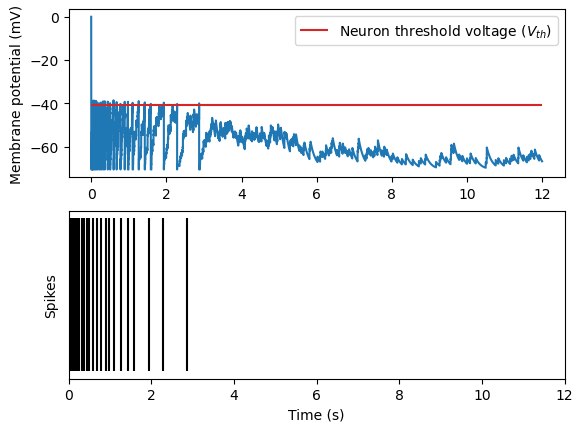

In [42]:
out_spikes=out_spikemon.spike_trains()
for n_index in range(1):
    fig, axs = plt.subplots(2)
    xlabel('Time (s)')
    axs[0].set(ylabel='Membrane potential (mV)')
    axs[1].set(ylabel='Spikes')
    axs[1].set_yticks([])
    
    axs[0].plot(out_statemon.t, out_statemon.vm[n_index]*1000)
    axs[1].vlines(x=[out_spikes[n_index][1:]],ymin=0,ymax=0.5,color="black")
    axs[0].hlines(y=[-40.6],xmin=0,xmax=DURATION,color="tab:red",label="Neuron threshold voltage ($V_{th}$)")
    axs[1].set_xlim([0,DURATION])
    axs[0].legend()

# BSNN test

In [45]:
print("Testing...")
    
G_input = SpikeGeneratorGroup(N, indices_test, times_test,dt=dt)
G_hidden = NeuronGroup(N, eqs, threshold='vm>V_th', reset='vm = V_r', method='euler',dt=dt)
G_output = NeuronGroup(1, eqs, threshold='vm>V_th', reset='vm = V_r', method='euler',dt=dt)
    
S_exc = Synapses(G_input, G_hidden,'w:volt', on_pre='vm+=w',dt=dt)
S_exc.connect(i='j')
S_exc.w = w_exc_stored * mV

S_inh = Synapses(G_input, G_hidden,'w:volt', on_pre='vm-=w',dt=dt)
S_inh.connect(condition='i!=j')
S_inh.w = w_inh_stored * mV
    
S_out = Synapses(G_hidden, G_output,'w:volt', on_pre='vm+=w',dt=dt)
S_out.connect()
S_out.w = np.abs(V_th)/N
    
input_spikemon = SpikeMonitor(G_input)
hidden_spikemon = SpikeMonitor(G_hidden)
out_spikemon = SpikeMonitor(G_output)

hidden_statemon = StateMonitor(G_hidden,variables=["vm"],record=np.arange(N))
out_statemon = StateMonitor(G_output,variables=["vm"],record=0)
run(DURATION)

Testing...


# Test results

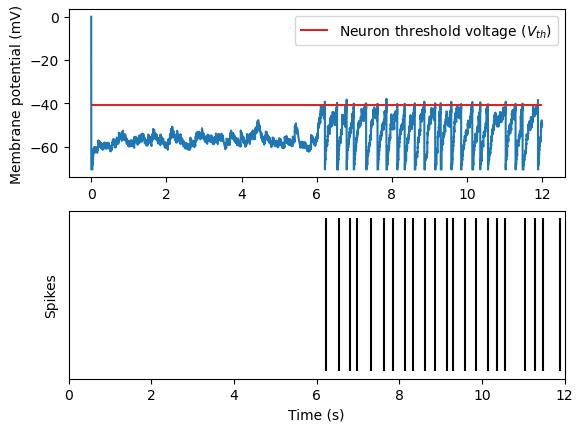

In [46]:
out_spikes=out_spikemon.spike_trains()
for n_index in range(1):
    fig, axs = plt.subplots(2)
    xlabel('Time (s)')
    axs[0].set(ylabel='Membrane potential (mV)')
    axs[1].set(ylabel='Spikes')
    axs[1].set_yticks([])
    
    axs[0].plot(out_statemon.t, out_statemon.vm[n_index]*1000)
    axs[1].vlines(x=[out_spikes[n_index][1:]],ymin=0,ymax=0.5,color="black")
    axs[0].hlines(y=[-40.6],xmin=0,xmax=DURATION,color="tab:red",label="Neuron threshold voltage ($V_{th}$)")
    axs[1].set_xlim([0,DURATION])
    axs[0].legend()